### Fourier Transform Solution of Unbounded Poisson Problems

In [1]:
%matplotlib inline

import numpy as np
from scipy.fft import fftn, ifftn
from scipy.special import erf, expi, exp1, sici
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import axes_grid1

def add_colorbar(im, ax, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

pi = np.pi

plt.rcParams['figure.dpi'] = 200

As a test problem, we will use a Gaussian distribution of charge
$$ \rho = \frac{1}{(2\pi)^{3/2}\sigma^3} \exp\left(-\frac{x^2+y^2+z^2}{2\sigma^2}\right) $$
with width $\sigma$.

The exact solution over all space is
$$ \phi(x,y,z) = \frac{1}{4\pi\sqrt{x^2+y^2+z^2}} \textrm{erf}\left(\frac{\sqrt{x^2+y^2+z^2}}{\sqrt{2}\sigma}\right) $$

We will solve this problem on a cubic domain of size $[-0.5,0.5]^3$.

Here is the test problem, along with a function to plot the results of our experiments

In [2]:
def rho3d(x,y,z,sigma):
    r = np.sqrt(x**2+y**2+z**2)
    return 1/((2*np.pi)**1.5 * sigma**3) * np.exp(-r**2/(2*sigma**2))

def phi3dExact(x,y,z,sigma):
    r = np.sqrt(x**2+y**2+z**2)
    # need l'Hopital's rule...
    return np.where(r==0, 1/( (2*pi)**1.5 * sigma ), \
        1/(4*np.pi*np.sqrt(x**2+y**2+z**2)) * erf(np.sqrt(x**2+y**2+z**2)/(np.sqrt(2)*sigma)) )

# some error norms
def normMax(x):
    return np.max(np.abs(x.flatten()))
def normRMS(x):
    return np.sqrt(np.average(x**2))

def plotit(phi, ans):
    error = np.abs(ans-phi)/ans
    L2error = normRMS(error)
    print(f"RMS error: {L2error}")
    inferror = normMax(error)
    print(f"max-norm error: {inferror}")

    fig, ax = plt.subplots(2,3)
    c0 = ax[0,0].imshow(ans[:,:,N//2], extent=(xmin,xmax,xmin,xmax), origin='lower')
    cb0 = add_colorbar(c0, ax[0,0])
    ax[1,0].plot(ans[:,N//2,N//2])
    ax[1,0].set_xlabel("exact")

    c1 = ax[0,1].imshow(phi[:,:,N//2], extent=(xmin,xmax,xmin,xmax), origin='lower')
    cb1 = add_colorbar(c1, ax[0,1])
    ax[1,1].set_xlabel("solution")
    ax[1,1].plot(phi[:,N//2,N//2])

    c2 = ax[0,2].imshow(error[:,:,N//2], extent=(xmin,xmax,xmin,xmax), origin='lower')
    cb2 = add_colorbar(c2, ax[0,2])
    ax[1,2].set_xlabel("error")
    ax[1,2].plot(error[:,N//2,N//2])

    plt.tight_layout();

The "unbounded" Poisson problem is the solution $\phi$ to
$$ \nabla^2 \phi(\mathbf{x}) = \rho(\mathbf{x})\quad \textrm{where}\quad\phi(\mathbf{x})\rightarrow0\ \mathrm{for}\ |\mathbf{x}|\rightarrow\infty$$
but where the solution is computed only on a finite grid. Thus, there is no
condition explicitly applied to the boundaries.

The Green's function for the Laplacian operator is
$$ G(\mathbf{x}) = \frac{1}{4\pi|\mathbf{x}|} $$
and the usual approach is to express convolution with the Green's function as
multiplication in Fourier space so that
$$ \hat{\phi}(\mathbf{k}) = \hat{G}(\mathbf{k}) \hat{\rho} $$
The Fourier transform of $G(\mathbf{x})$ is
$$ \hat{G}(\mathbf{k}) = \frac{1}{|\mathbf{k}|^2} $$
This is singular at wavevector $\mathbf{k}=0$. 

As mentioned in the periodic boundary notebook, for periodic boundary conditions this singularity is not a problem. The integrability condition that $\int_\Omega \rho\ d\Omega = 0$ (where $\Omega$ is the solution domain) means the value of  $\hat{G}_{0,0,0}$ doesn't matter; we usually set it to zero.
 
For non-periodic boundaries, the first trick to employ is to double the size of the grid in all dimensions and pad the source with zeros. This gives us the solution to a non-periodic problem. After performing the convolution, we then restrict the resulting solution to the original $N^3$ domain.
 
As to the singluar kernel, in the case of a non-periodic domain we don't have the integrability condition to fall back on, and we need somehow to deal with the singularity. Because the Green's function in this case is radially symmetric, we can write it as
$$ G(r) = \frac{\xi(r)}{4\pi|r|} $$
where $\xi(r)$ is some function which acts to regularize the kernel, to make the singularity more benign.

First, let's try writing $G(\mathbf{x})$ on a grid and 
simply try setting $G(0) = 0$ (in real space, not Fourier space), then transforming to find $\hat{G}$

RMS error: 0.000737025440503847
max-norm error: 0.021419574977648164


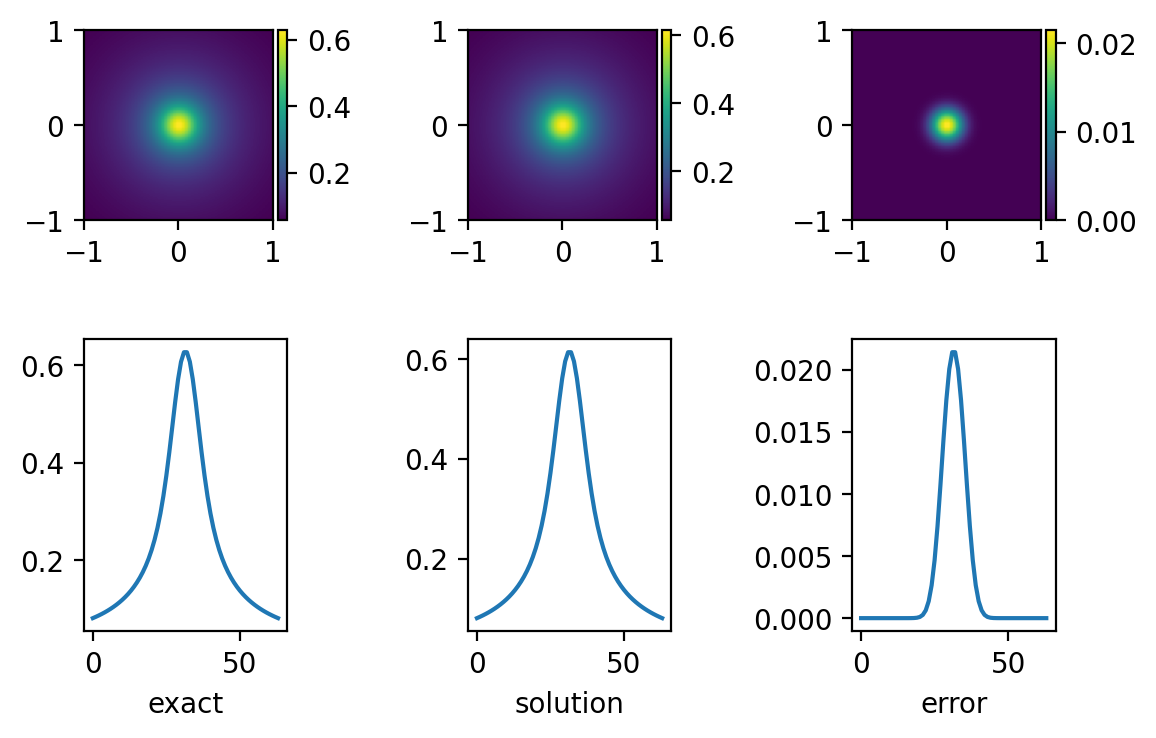

In [3]:
# problem setup
xmin, xmax = np.array([-0.5,0.5])*2 # change the box length here
L = xmax - xmin
sigma = 0.05 * L # and scale the width of the source to match
N = 64

# Sample source and solution on grid
h = L/N
x1d = np.arange(xmin+h/2, xmax+h/2, h) # sample from middle of grid cell
x, y, z = np.meshgrid(x1d,x1d,x1d)
rho = rho3d(x,y,z,sigma)
ans = phi3dExact(x,y,z,sigma)

# get Green's function in real space 
M = 2*N
i = np.arange(0,M)
i = np.where(i > N, M-i, i)
na = np.newaxis
G = 1/( 4*pi*np.sqrt( (i[:,na,na]*h)**2 + (i[na,:,na]*h)**2 + (i[na,na,:]*h)**2)+1.0e-38)
# set infinity to zero!
G[0,0,0] = 0
# and transform to Fourier space 
# (scipy's default is not to multiply by a normalization in the forward direction)
Ghat = fftn(G) / G.size * (2*L)**3

# and convolve with the padded source
fargs = { 'workers':12, 'overwrite_x':True }
phi = ifftn( Ghat * fftn(np.pad(rho,(0,N)),**fargs), **fargs )[:N,:N,:N].real

plotit(phi, ans)

We get a solution, but the accuracy is not very satisfactory.  Let's look at the convergence of this method with increasing $N$

In [4]:
def simple(N):
    # problem setup
    xmin, xmax = np.array([-0.5,0.5])*1
    L = xmax - xmin
    sigma = 0.05 * L

    # Sample source and solution on grid
    h = L/N
    x1d = np.arange(xmin+h/2, xmax+h/2, h) # sample from middle of grid cell
    x, y, z = np.meshgrid(x1d,x1d,x1d)
    rho = -rho3d(x,y,z,sigma)
    ans = phi3dExact(x,y,z,sigma)

    # get Green's function in real space 
    M = 2*N
    i = np.arange(0,M)
    i = np.where(i > N, M-i, i)
    na = np.newaxis
    G = 1/( 4*pi*np.sqrt( (i[:,na,na]*h)**2 + (i[na,:,na]*h)**2 + (i[na,na,:]*h)**2)+1.0e-38)
    G[0,0,0] = 0
    # and transform to Fourier space 
    # (scipy's default is not to multiply by a normalization in the forward direction)
    Ghat = fftn(G) / G.size * (2*L)**3

    # and convolve with padded source
    fargs = { 'workers':12, 'overwrite_x':True }
    phi = ifftn( Ghat * fftn(np.pad(-rho,(0,N)),**fargs), **fargs )[:N,:N,:N].real
    
    error = phi-ans
    return normMax(error)

Text(0, 0.5, '$|\\phi-\\phi_e|_\\infty$')

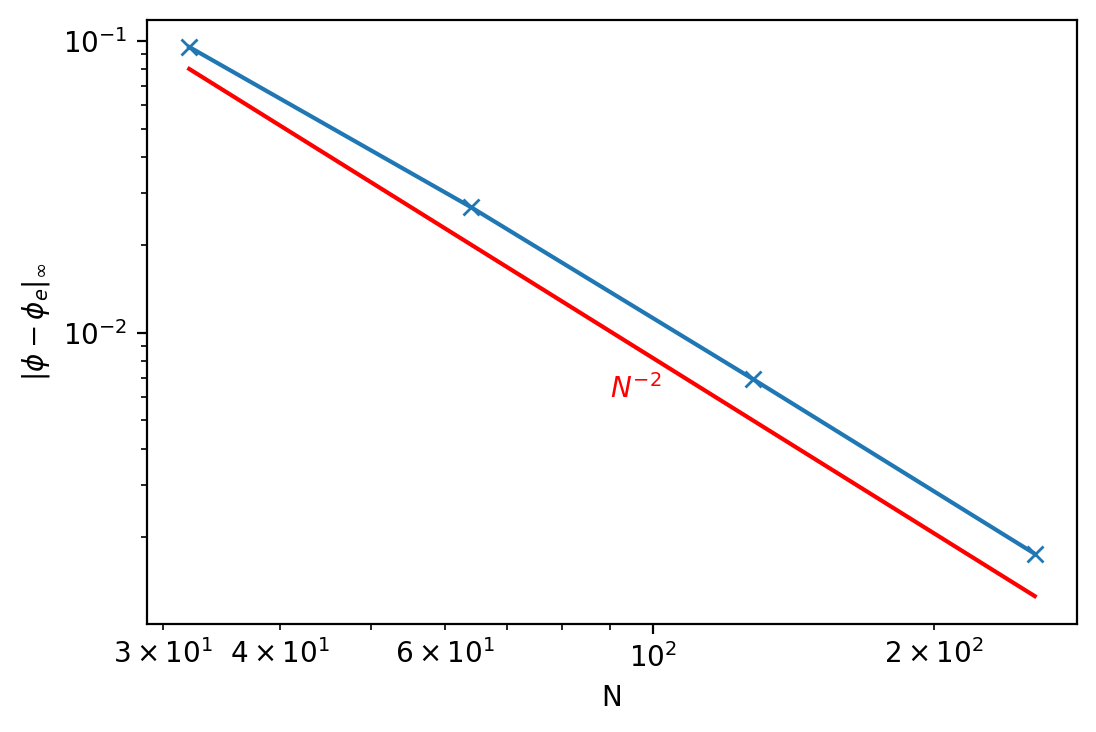

In [5]:
n = []
e = []
for i in range(5,9):
    N = 2**i
    n.append(N)
    e.append(simple(N))

fig,ax = plt.subplots()
ax.loglog(n,e,'-x')
ax.loglog([32,256],[0.08,0.08/64],'r')
ax.text(90,.006,r'$N^{-2}$',c='r')
ax.set_xlabel('N')
ax.set_ylabel(r'$|\phi-\phi_e|_\infty$')

The error decreases as $N^{-2}$, but we need to do $O((N\log N)^3)$ work to achieve
this; not terribly encouraging...

We clearly need a more careful approach to regularizing the kernel. M. M. Hejlesen, G. Winckelmans, & J. H. Walther (2013, *Non-singular Green’s Functions for the Unbounded Poisson Equation in One, Two and Three Dimensions*, Applied Mathematics Letters, 89, pp. 28–34) present such a treatment.

They suggest applying a cutoff function in Fourier space which is non-zero only over the wavenumbers actually sampled by the calculation on the grid
$$\hat{\xi}(k) = \left\{ \begin{array}{ll} \frac{1}{2}, & 0 < k \le \frac{k_n}{2} \\
0, & k > \frac{k_n}{2} \end{array}\right. $$
where $k_n = 2\pi/h$ is wavenumber corresponding to the mesh size $h$ and $k_n/2$ is then the highest wavenumber the grid can resolve (by the Nyquist sampling theorem).

Because of the radial symmetry of the Green's function, the Fourier transform of this
$\hat{G}(\mathbf{k}) = \xi(\mathbf{k})/|\mathbf{k}|^2$ can be done analytically. The result, in three dimensions, is
$$ G(r) = \frac{1}{2\pi^2\sigma}\frac{Si(\rho)}{\rho} $$
where $\sigma = h/\pi$, $\rho=\pi r / h$, and where $Si(x)$ is the *sine integral*
$$ Si(x) = \int_0^x \frac{\sin(t)}{t} dt $$
and is provided by scipy by the function `special.sici`. (NB: `sici` provides both the
sine and cosine integral functions; the sine integral is `sici(x)[0]`)

The proceedure for solving an open boundary problem is then to compute this real-space Green's function on our doubled grid and then convolve it with the source $\rho$ using FFT's

Here we evaluate the regularized $G(\mathbf{r})$ on the doubled grid and take its discrete transform

In [6]:
def spectralGhat(N,L):
    """
    Unbounded Laplace operater Fourier Green's function in 3D on a grid of N with
    side length L
    """
    h = L/N
    sigma = h/pi 

    i = np.arange(0,2*N)
    i = np.where(i>N,2*N-i,i)
    na = np.newaxis
    #grid of pi*r/h 
    rho = pi*np.sqrt(i[:,na,na]**2+i[na,:,na]**2+i[na,na,:]**2)
    fac = 1/(2*pi**2 * sigma)
    G = fac * sici(rho)[0]/(rho + 1e-38)
    G[0,0,0] = fac
    # transform into Fourier space
    Ghat = fftn(G)/G.size * (2*L)**3
    return Ghat

Solving the same problem as before, we find a solution accurate to roudoff error:

RMS error: 3.470577888520546e-16
max-norm error: 1.5536694191245734e-15


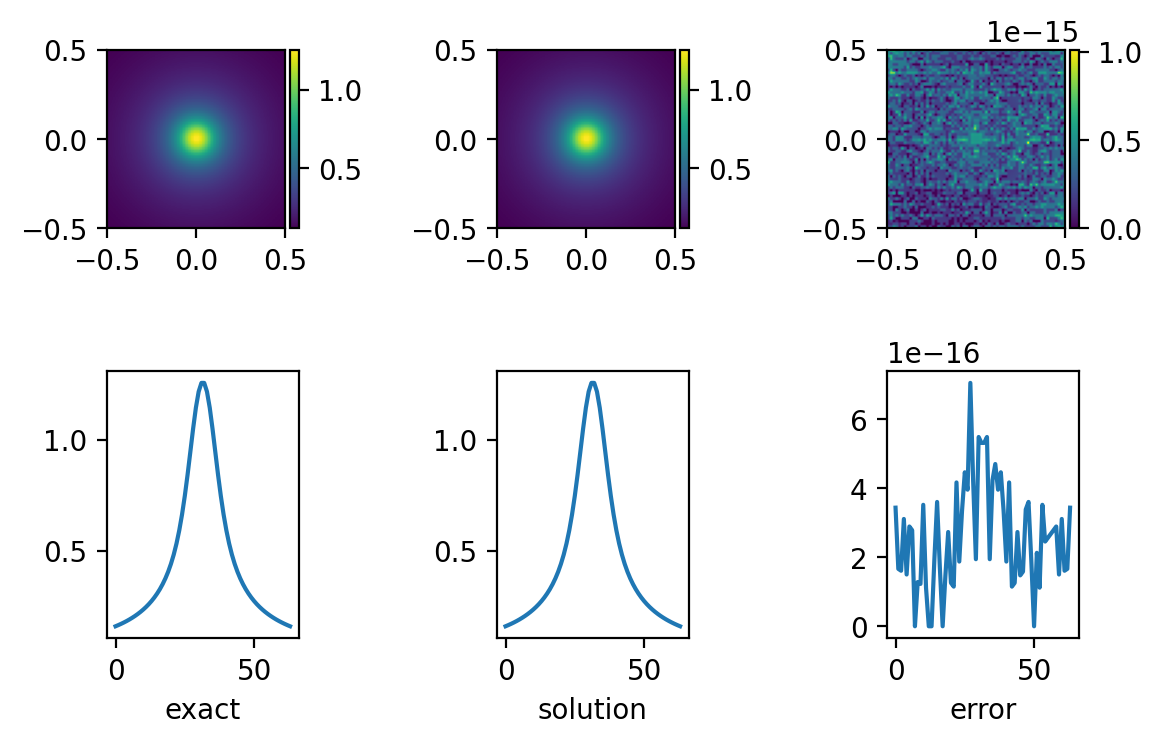

In [7]:
# problem setup
xmin, xmax = np.array([-0.5,0.5])*1
L = xmax - xmin
sigma = 0.05 * L
N = 64

# Sample source and solution on grid
h = L/N
x1d = np.arange(xmin+h/2, xmax+h/2, h) # sample from middle of grid cell
x, y, z = np.meshgrid(x1d,x1d,x1d)
rho = -rho3d(x,y,z,sigma)
ans = phi3dExact(x,y,z,sigma)

# get Fourier Green's function
Ghat = spectralGhat(N,L)

# and convolve with padded source
fargs = { 'workers':12, 'overwrite_x':True }
phi = ifftn( Ghat * fftn(np.pad(-rho,(0,N)),**fargs), **fargs )[:N,:N,:N].real

plotit(phi, ans)

Examining convergence as before, we find very rapid convergence with $N$. This is an example of *spectral convergence* -- the error decreases exponentially as $O(h^N)$, faster than $O(h^p)$ for any order $p$:

In [8]:
def spectral(N):
    # problem setup
    xmin, xmax = np.array([-0.5,0.5])*1
    L = xmax - xmin
    sigma = 0.05 * L

    # Sample source and solution on grid
    h = L/N
    x1d = np.arange(xmin+h/2, xmax+h/2, h) # sample from middle of grid cell
    x, y, z = np.meshgrid(x1d,x1d,x1d)
    rho = -rho3d(x,y,z,sigma)
    ans = phi3dExact(x,y,z,sigma)

    Ghat = spectralGhat(N,L)

    # and convolve with padded source
    fargs = { 'workers':12, 'overwrite_x':True }
    phi = ifftn( Ghat * fftn(np.pad(-rho,(0,N)),**fargs), **fargs )[:N,:N,:N].real
    
    error = phi-ans
    return normMax(error)

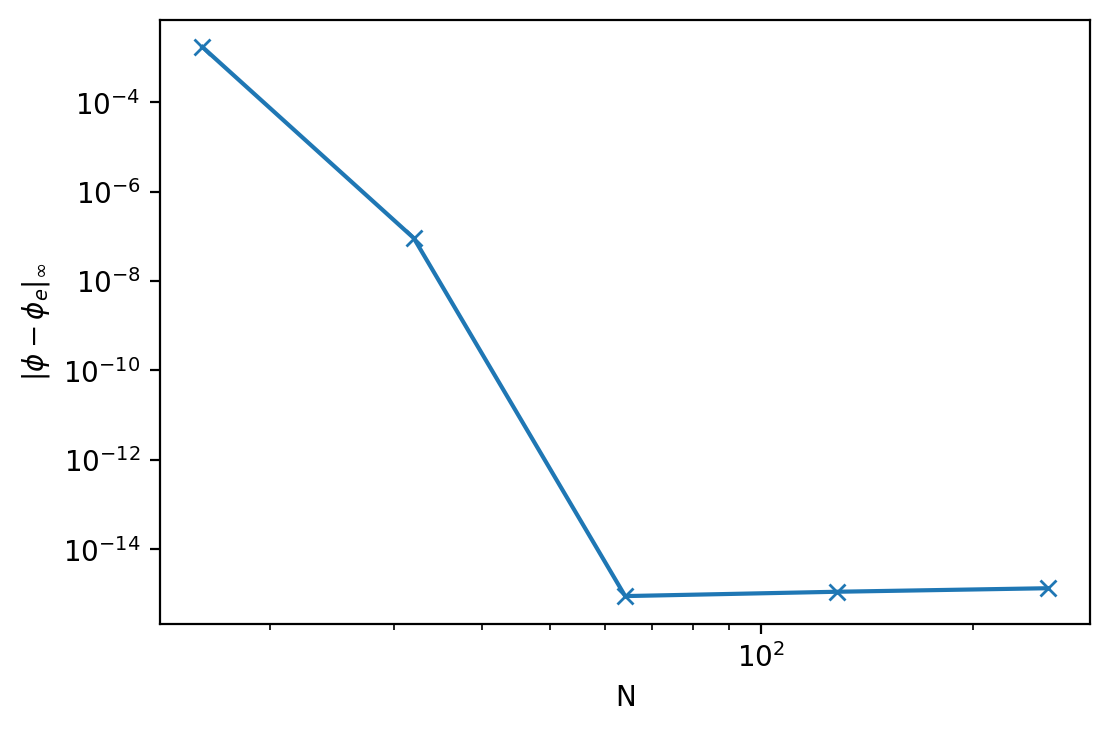

In [9]:
n = []
e = []
for i in range(4,9):
    N = 2**i
    n.append(N)
    e.append(spectral(N))

fig,ax = plt.subplots()
ax.loglog(n,e,'-x')
ax.set_xlabel('N')
ax.set_ylabel(r'$|\phi-\phi_e|_\infty$');

A useful tool is to *memoize* the computation of $\hat{G}$:


Usage is:   
`
 solver = SolveOpenPoisson()
 phi = solver(rho,L)
`

`solver` will only compute Ghat the first time it is called; subsequent calls will use the cached array as long as the parameters are not changed. (True memoization would store all of the kernels already computed; for this application this would use too much memory!)

In [10]:
class SolveOpenPoisson:
    def __init__(self):
        self.Ghat = None
        self.N = 0
        self.L = 0
        
    def __call__(self, rho, L):
        N = rho.shape[0]
        if self.Ghat is None or N != self.N or L != self.L:
            self.N = N
            self.L = L
            self.Ghat = self.spectralGhat(N,L)
            
        fargs = { 'workers':12, 'overwrite_x':True }
        phi = ifftn( self.Ghat * fftn(np.pad(-rho,(0,N)),**fargs), **fargs )[:N,:N,:N].real
        return phi
    
    def spectralGhat(self,N,L):
        """
        Unbounded Laplace operater Fourier Green's function in 3D on a grid of N with
        side length L
        """
        h = L/N
        sigma = h/pi 

        i = np.arange(0,2*N)
        i = np.where(i>N,2*N-i,i)
        na = np.newaxis
        #grid of pi*r/h 
        rho = pi*np.sqrt(i[:,na,na]**2+i[na,:,na]**2+i[na,na,:]**2)
        fac = 1/(2*pi**2 * sigma)
        G = fac * sici(rho)[0]/(rho + 1e-38)
        G[0,0,0] = fac
        # transform into Fourier space
        Ghat = fftn(G)/G.size * (2*L)**3
        print("generating")
        return Ghat

generating
RMS error: 3.470577888520546e-16
max-norm error: 1.5536694191245734e-15


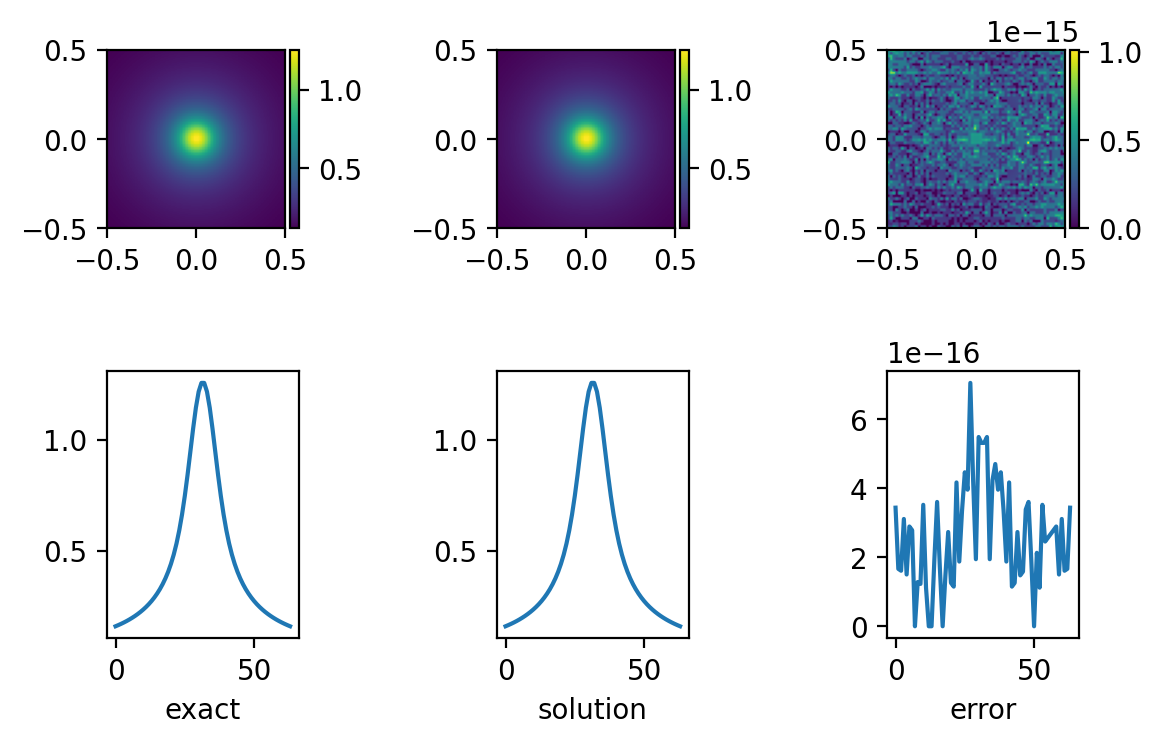

In [11]:
# problem setup
xmin, xmax = np.array([-0.5,0.5])*1
L = xmax - xmin
sigma = 0.05 * L
N = 64

# Sample source and solution on grid
h = L/N
x1d = np.arange(xmin+h/2, xmax+h/2, h) # sample from middle of grid cell
x, y, z = np.meshgrid(x1d,x1d,x1d)
rho = -rho3d(x,y,z,sigma)
ans = phi3dExact(x,y,z,sigma)

solver = SolveOpenPoisson()
phi = solver(rho, L)

plotit(phi, ans)